<a href="https://colab.research.google.com/github/EyesWatch/PerpBacktest/blob/main/CROSSEMA%2BMACD_FutureBacktest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Instalation des pre requis***

In [1]:
pip install python-binance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 2.7 MB/s 
     |████████████████████████████████| 45 kB 701 kB/s 
     |████████████████████████████████| 288 kB 26.1 MB/s 
     |████████████████████████████████| 112 kB 31.5 MB/s 
     |████████████████████████████████| 1.1 MB 39.4 MB/s 
     |████████████████████████████████| 94 kB 1.9 MB/s 
     |████████████████████████████████| 144 kB 50.3 MB/s 
     |████████████████████████████████| 271 kB 40.7 MB/s 
     |████████████████████████████████| 749 kB 19.4 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2022.6.2
    Uninstalling regex-2022.6.2:
      Successfully uninstalled regex-2022.6.2


In [2]:
pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.1-py3-none-any.whl size=28985 sha256=87c3ecefd85b86da1a4dbb2f99a0fce1c6c6a134f47ff6c183ed746dba2ae986
  Stored in directory: /root/.cache/pip/wheels/bc/2a/c2/a56e77d07edc16a1fa7fb012667e55cb0643cfa65996bddecc
Successfully built ta


In [3]:
pip install pandas_ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 9.4 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218923 sha256=e14b62211151fc356844ebd48db7eed88ae3f4b458e501b4b45874234e6b21d6
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta


***DEFINITION DES PARAMETRES DE BASE***

In [4]:
# -- Import --
import pandas as pd
from binance.client import Client
import ta
import matplotlib.pyplot as plt
import numpy as np
import math
import requests
import pandas_ta as pda

# -- Define Binance Client --
client = Client()

# -- You can change the crypto pair ,the start date and the time interval below --
pairName = "ETHUSDT"
startDate = "01 january 2017"
timeInterval = Client.KLINE_INTERVAL_1HOUR
trix_window = 9

# -- Load all price data from binance API --
klinesT = client.get_historical_klines(pairName, timeInterval, startDate)

# -- Define your dataset --
df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
df['close'] = pd.to_numeric(df['close'])
df['high'] = pd.to_numeric(df['high'])
df['low'] = pd.to_numeric(df['low'])
df['open'] = pd.to_numeric(df['open'])

# -- Set the date to index --
df = df.set_index(df['timestamp'])
df.index = pd.to_datetime(df.index, unit='ms')
del df['timestamp']





print("Data loaded 100%")

# -- Uncomment the line below if you want to check your price dataset --
# df

Data loaded 100%


***DEFINITION DES CLASSES***

In [5]:



def chop(high, low, close, window=14):
    ''' Choppiness indicator
    '''
    tr1 = pd.DataFrame(high - low).rename(columns={0: 'tr1'})
    tr2 = pd.DataFrame(abs(high - close.shift(1))
                       ).rename(columns={0: 'tr2'})
    tr3 = pd.DataFrame(abs(low - close.shift(1))
                       ).rename(columns={0: 'tr3'})
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis=1, join='inner').dropna().max(axis=1)
    atr = tr.rolling(1).mean()
    highh = high.rolling(window).max()
    lowl = low.rolling(window).min()
    chop_serie = 100 * np.log10((atr.rolling(window).sum()) /
                          (highh - lowl)) / np.log10(window)
    return pd.Series(chop_serie, name="CHOP")

def fear_and_greed(close):
    ''' Fear and greed indicator
    '''
    response = requests.get("https://api.alternative.me/fng/?limit=0&format=json")
    dataResponse = response.json()['data']
    fear = pd.DataFrame(dataResponse, columns = ['timestamp', 'value'])

    fear = fear.set_index(fear['timestamp'])
    fear.index = pd.to_datetime(fear.index, unit='s')
    del fear['timestamp']
    df = pd.DataFrame(close, columns = ['close'])
    df['fearResult'] = fear['value']
    df['FEAR'] = df['fearResult'].ffill()
    df['FEAR'] = df.FEAR.astype(float)
    return pd.Series(df['FEAR'], name="FEAR")



class VMC():
    """ VuManChu Cipher B + Divergences 
        Args:
            high(pandas.Series): dataset 'High' column.
            low(pandas.Series): dataset 'Low' column.
            close(pandas.Series): dataset 'Close' column.
            wtChannelLen(int): n period.
            wtAverageLen(int): n period.
            wtMALen(int): n period.
            rsiMFIperiod(int): n period.
            rsiMFIMultiplier(int): n period.
            rsiMFIPosY(int): n period.
    """

    def __init__(
        self: pd.Series,
        open: pd.Series,
        high: pd.Series,
        low: pd.Series,
        close: pd.Series,
        wtChannelLen: int = 9,
        wtAverageLen: int = 12,
        wtMALen: int = 3,
        rsiMFIperiod: int = 60,
        rsiMFIMultiplier: int = 150,
        rsiMFIPosY: int = 2.5
    ) -> None:
        self._high = high
        self._low = low
        self._close = close
        self._open = open
        self._wtChannelLen = wtChannelLen
        self._wtAverageLen = wtAverageLen
        self._wtMALen = wtMALen
        self._rsiMFIperiod = rsiMFIperiod
        self._rsiMFIMultiplier = rsiMFIMultiplier
        self._rsiMFIPosY = rsiMFIPosY

        self._run()
        self.wave_1()

    def _run(self) -> None:
        self.hlc3 = (self._close + self._high + self._low)
        self._esa = ta.trend.ema_indicator(
            close=self.hlc3, window=self._wtChannelLen)
        self._de = ta.trend.ema_indicator(
            close=abs(self.hlc3 - self._esa), window=self._wtChannelLen)
        self._rsi = ta.trend.sma_indicator(self._close, self._rsiMFIperiod)
        self._ci = (self.hlc3 - self._esa) / (0.015 * self._de)

    def wave_1(self) -> pd.Series:
        """VMC Wave 1 
        Returns:
            pandas.Series: New feature generated.
        """
        wt1 = ta.trend.ema_indicator(self._ci, self._wtAverageLen)
        return pd.Series(wt1, name="wt1")

    def wave_2(self) -> pd.Series:
        """VMC Wave 2
        Returns:
            pandas.Series: New feature generated.
        """
        wt2 = ta.trend.sma_indicator(self.wave_1(), self._wtMALen)
        return pd.Series(wt2, name="wt2")

    def money_flow(self) -> pd.Series:
        """VMC Money Flow
        Returns:
            pandas.Series: New feature generated.
        """
        mfi = ((self._close - self._open) /
               (self._high - self._low)) * self._rsiMFIMultiplier
        rsi = ta.trend.sma_indicator(mfi, self._rsiMFIperiod)
        money_flow = rsi - self._rsiMFIPosY
        return pd.Series(money_flow, name="money_flow")


def heikinAshiDf(df):
    df['HA_Close'] = (df.open + df.high + df.low + df.close)/4
    ha_open = [(df.open[0] + df.close[0]) / 2]
    [ha_open.append((ha_open[i] + df.HA_Close.values[i]) / 2)
     for i in range(0, len(df)-1)]
    df['HA_Open'] = ha_open
    df['HA_High'] = df[['HA_Open', 'HA_Close', 'high']].max(axis=1)
    df['HA_Low'] = df[['HA_Open', 'HA_Close', 'low']].min(axis=1)
    return df


def volume_anomality(df, volume_window=10):
    dfInd = df.copy()
    dfInd["VolAnomaly"] = 0
    dfInd["PreviousClose"] = dfInd["close"].shift(1)
    dfInd['MeanVolume'] = dfInd['volume'].rolling(volume_window).mean()
    dfInd['MaxVolume'] = dfInd['volume'].rolling(volume_window).max()
    dfInd.loc[dfInd['volume'] > 1.5 * dfInd['MeanVolume'], "VolAnomaly"] = 1
    dfInd.loc[dfInd['volume'] > 2 * dfInd['MeanVolume'], "VolAnomaly"] = 2
    dfInd.loc[dfInd['volume'] >= dfInd['MaxVolume'], "VolAnomaly"] = 3
    dfInd.loc[dfInd['PreviousClose'] > dfInd['close'],
              "VolAnomaly"] = (-1) * dfInd["VolAnomaly"]
    return dfInd["VolAnomaly"]

class SuperTrend():
    def __init__(
        self,
        high,
        low,
        close,
        atr_window=10,
        atr_multi=3
    ):
        self.high = high
        self.low = low
        self.close = close
        self.atr_window = atr_window
        self.atr_multi = atr_multi
        self._run()
        
    def _run(self):
        # calculate ATR
        price_diffs = [self.high - self.low, 
                    self.high - self.close.shift(), 
                    self.close.shift() - self.low]
        true_range = pd.concat(price_diffs, axis=1)
        true_range = true_range.abs().max(axis=1)
        # default ATR calculation in supertrend indicator
        atr = true_range.ewm(alpha=1/self.atr_window,min_periods=self.atr_window).mean() 
        # atr = ta.volatility.average_true_range(high, low, close, atr_period)
        # df['atr'] = df['tr'].rolling(atr_period).mean()
        
        # HL2 is simply the average of high and low prices
        hl2 = (self.high + self.low) / 2
        # upperband and lowerband calculation
        # notice that final bands are set to be equal to the respective bands
        final_upperband = upperband = hl2 + (self.atr_multi * atr)
        final_lowerband = lowerband = hl2 - (self.atr_multi * atr)
        
        # initialize Supertrend column to True
        supertrend = [True] * len(self.close)
        
        for i in range(1, len(self.close)):
            curr, prev = i, i-1
            
            # if current close price crosses above upperband
            if self.close[curr] > final_upperband[prev]:
                supertrend[curr] = True
            # if current close price crosses below lowerband
            elif self.close[curr] < final_lowerband[prev]:
                supertrend[curr] = False
            # else, the trend continues
            else:
                supertrend[curr] = supertrend[prev]
                
                # adjustment to the final bands
                if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                    final_lowerband[curr] = final_lowerband[prev]
                if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                    final_upperband[curr] = final_upperband[prev]

            # to remove bands according to the trend direction
            if supertrend[curr] == True:
                final_upperband[curr] = np.nan
            else:
                final_lowerband[curr] = np.nan
                
        self.st = pd.DataFrame({
            'Supertrend': supertrend,
            'Final Lowerband': final_lowerband,
            'Final Upperband': final_upperband
        })
        
    def super_trend_upper(self):
        return self.st['Final Upperband']
        
    def super_trend_lower(self):
        return self.st['Final Lowerband']
        
    def super_trend_direction(self):
        return self.st['Supertrend']
    
class MaSlope():
    """ Slope adaptative moving average
    """

    def __init__(
        self,
        close: pd.Series,
        high: pd.Series,
        low: pd.Series,
        long_ma: int = 200,
        major_length: int = 14,
        minor_length: int = 6,
        slope_period: int = 34,
        slope_ir: int = 25
    ):
        self.close = close
        self.high = high
        self.low = low
        self.long_ma = long_ma
        self.major_length = major_length
        self.minor_length = minor_length
        self.slope_period = slope_period
        self.slope_ir = slope_ir
        self._run()

    def _run(self):
        minAlpha = 2 / (self.minor_length + 1)
        majAlpha = 2 / (self.major_length + 1)
        # df = pd.DataFrame(data = [self.close, self.high, self.low], columns = ['close','high','low'])
        df = pd.DataFrame(data = {"close": self.close, "high": self.high, "low":self.low})
        df['hh'] = df['high'].rolling(window=self.long_ma+1).max()
        df['ll'] = df['low'].rolling(window=self.long_ma+1).min()
        df = df.fillna(0)
        df.loc[df['hh'] == df['ll'],'mult'] = 0
        df.loc[df['hh'] != df['ll'],'mult'] = abs(2 * df['close'] - df['ll'] - df['hh']) / (df['hh'] - df['ll'])
        df['final'] = df['mult'] * (minAlpha - majAlpha) + majAlpha

        ma_first = (df.iloc[0]['final']**2) * df.iloc[0]['close']

        col_ma = [ma_first]
        for i in range(1, len(df)):
            ma1 = col_ma[i-1]
            col_ma.append(ma1 + (df.iloc[i]['final']**2) * (df.iloc[i]['close'] - ma1))

        df['ma'] = col_ma
        pi = math.atan(1) * 4
        df['hh1'] = df['high'].rolling(window=self.slope_period).max()
        df['ll1'] = df['low'].rolling(window=self.slope_period).min()
        df['slope_range'] = self.slope_ir / (df['hh1'] - df['ll1']) * df['ll1']
        df['dt'] = (df['ma'].shift(2) - df['ma']) / df['close'] * df['slope_range'] 
        df['c'] = (1+df['dt']*df['dt'])**0.5
        df['xangle'] = round(180*np.arccos(1/df['c']) / pi)
        df.loc[df['dt']>0,"xangle"] = - df['xangle']
        self.df = df
        # print(df)

    def ma_line(self) -> pd.Series:
        """ ma_line
            Returns:
                pd.Series: ma_line
        """
        return self.df['ma']

    def x_angle(self) -> pd.Series:
        """ x_angle
            Returns:
                pd.Series: x_angle
        """
        return self.df['xangle']
    
def get_n_columns(df, columns, n=1):
    dt = df.copy()
    for col in columns:
        dt["n"+str(n)+"_"+col] = dt[col].shift(n)
    return dt

class CustomIndocators():


    def chop(high, low, close, window=14):
        """ Chopiness index
            Args:
                high(pd.Series): dataframe 'high' columns,
                low(pd.Series): dataframe 'low' columns,
                close(pd.Series): dataframe 'close' columns,
                window(int): the window length for the chopiness index,
            Returns:
                pd.Series: Chopiness index
        """
        tr1 = pd.DataFrame(high - low).rename(columns = {0:'tr1'})
        tr2 = pd.DataFrame(abs(high - close.shift(1))).rename(columns = {0:'tr2'})
        tr3 = pd.DataFrame(abs(low - close.shift(1))).rename(columns = {0:'tr3'})
        frames = [tr1, tr2, tr3]
        tr = pd.concat(frames, axis = 1, join = 'inner').dropna().max(axis = 1)
        atr = tr.rolling(1).mean()
        highh = high.rolling(window).max()
        lowl = low.rolling(window).min()
        chop = 100 * np.log10((atr.rolling(window).sum()) / (highh - lowl)) / np.log10(window)
        return pd.Series(chop, name="CHOP")

    def heikinAshiDf(df):
        """ HeikinAshi candles
            Args:
                df(pd.Dataframe): dataframe with 'open'|'high'|'low'|'close' columns
            Returns:
                pd.Dataframe: dataframe with 'HA_Open'|'HA_High'|'HA_Low'|'HA_Close' columns
        """
        df['HA_Close']=(df.open + df.high + df.low + df.close)/4
        ha_open = [ (df.open[0] + df.close[0]) / 2 ]
        [ ha_open.append((ha_open[i] + df.HA_Close.values[i]) / 2) \
        for i in range(0, len(df)-1) ]
        df['HA_Open'] = ha_open
        df['HA_High']=df[['HA_Open','HA_Close','high']].max(axis=1)
        df['HA_Low']=df[['HA_Open','HA_Close','low']].min(axis=1)
        return df

    def volume_anomality(df, volume_window=10):
        dfInd = df.copy()
        dfInd["VolAnomaly"] = 0
        dfInd["PreviousClose"] = dfInd["close"].shift(1)
        dfInd['MeanVolume'] = dfInd['volume'].rolling(volume_window).mean()
        dfInd['MaxVolume'] = dfInd['volume'].rolling(volume_window).max()
        dfInd.loc[dfInd['volume'] > 1.5 * dfInd['MeanVolume'], "VolAnomaly"] = 1
        dfInd.loc[dfInd['volume'] > 2 * dfInd['MeanVolume'], "VolAnomaly"] = 2
        dfInd.loc[dfInd['volume'] >= dfInd['MaxVolume'], "VolAnomaly"] = 3
        dfInd.loc[dfInd['PreviousClose'] > dfInd['close'],
                "VolAnomaly"] = (-1) * dfInd["VolAnomaly"]
        return dfInd["VolAnomaly"]



# TRIX
#Classe de féinition
class Trix():
    """ Trix indicator

        Args:
            close(pd.Series): dataframe 'close' columns,
            trixLength(int): the window length for each mooving average of the trix,
            trixSignal(int): the window length for the signal line
    """

    def __init__(
        self,
        close: pd.Series,
        trixLength: int = 9,
        trixSignal: int = 21
    ):
        self.close = close
        self.trixLength = trixLength
        self.trixSignal = trixSignal
        self._run()

    def _run(self):
        self.trixLine = ta.trend.ema_indicator(
            ta.trend.ema_indicator(
                ta.trend.ema_indicator(
                    close=self.close, window=self.trixLength),
                window=self.trixLength), window=self.trixLength)
        self.trixPctLine = self.trixLine.pct_change()*100
        self.trixSignalLine = ta.trend.sma_indicator(
            close=self.trixPctLine, window=self.trixSignal)
        self.trixHisto = self.trixPctLine - self.trixSignalLine

    def trix_line(self) -> pd.Series:
        """ trix line

            Returns:
                pd.Series: trix line
        """
        return pd.Series(self.trixLine, name="TRIX_LINE")

    def trix_pct_line(self) -> pd.Series:
        """ trix percentage line

            Returns:
                pd.Series: trix percentage line
        """
        return pd.Series(self.trixPctLine, name="TRIX_PCT_LINE")

    def trix_signal_line(self) -> pd.Series:
        """ trix signal line

            Returns:
                pd.Series: trix siganl line
        """
        return pd.Series(self.trixSignal, name="TRIX_SIGNAL_LINE")

    def trix_histo(self) -> pd.Series:
        """ trix histogram

            Returns:
                pd.Series: trix histogram
        """
        return pd.Series(self.trixHisto, name="TRIX_HISTO")


***DEFINITION DES INDICATEURS***

In [6]:
# -- Drop all columns we do not need --
df.drop(df.columns.difference(['open','high','low','close','volume']), 1, inplace=True)

# -- Indicators, you can edit every value --
# -- Exponential Moving Average --
df['EMA1']= ta.trend.ema_indicator(close=df['close'], window=7)
df['EMA2']= ta.trend.ema_indicator(close=df['close'], window=30)
df['EMA3']= ta.trend.ema_indicator(close=df['close'], window=50)
df['EMA4']= ta.trend.ema_indicator(close=df['close'], window=100)
df['EMA5']= ta.trend.ema_indicator(close=df['close'], window=121)
df['EMA6']= ta.trend.ema_indicator(close=df['close'], window=200)
df['EMA7']= ta.trend.ema_indicator(close=df['close'], window=500)
# -- Stochasitc RSI --
#df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=14, smooth1=3, smooth2=3)
# -- Ichimoku --
df['kijun'] = ta.trend.ichimoku_base_line(df['high'], df['low'])
df['tenkan'] = ta.trend.ichimoku_conversion_line(df['high'], df['low'])
df['SSA'] = ta.trend.ichimoku_a(df['high'], df['low'])
df['SSB'] = ta.trend.ichimoku_b(df['high'], df['low'])
df['ssa25'] = ta.trend.ichimoku_a(df['high'], df['low']).shift(25)
df['ssb25'] = ta.trend.ichimoku_b(df['high'], df['low']).shift(25)
df['ssa52'] = ta.trend.ichimoku_a(df['high'], df['low']).shift(50)
df['ssb52'] = ta.trend.ichimoku_b(df['high'], df['low']).shift(50)
df['STOCH_RSI']=ta.momentum.stochrsi(df['close'])
df['EMA50']=ta.trend.ema_indicator(df['close'], 50)
df['close25'] = df['close'].shift(25)
df['close1'] = df['close'].shift(1)
# Cross EMA +RSI
df['ema1'] = ta.trend.ema_indicator(close = df['close'], window = 25) # Moyenne exponentiel courte
df['ema2'] = ta.trend.ema_indicator(close = df['close'], window = 45) # Moyenne exponentiel moyenne
df['sma_long'] = ta.trend.sma_indicator(close = df['close'], window = 600) # Moyenne simple longue
df['stoch_rsi'] = ta.momentum.stochrsi(close = df['close'], window = 14) # Stochastic RSI non moyenné (K=1 sur Trading View)
# -- BIGWILL --
stochOverBought = 0.8
stochOverSold = 0.2
willOverSold = -85
willOverBought = -10
aoParam1 = 6
aoParam2 = 22
stochWindow = 14
willWindow = 14
df['AO']= ta.momentum.awesome_oscillator(df['high'],df['low'],window1=aoParam1,window2=aoParam2)
df['EMA200'] =ta.trend.ema_indicator(close=df['close'], window=200)   
#df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=stochWindow)
df['WillR'] = ta.momentum.williams_r(high=df['high'], low=df['low'], close=df['close'], lbp=willWindow)
df['EMA100'] =ta.trend.ema_indicator(close=df['close'], window=100)
df['EMA200'] =ta.trend.ema_indicator(close=df['close'], window=200)
#df['ema1'] = ta.trend.ema_indicator(close = df['close'], window = 5) # Moyenne exponentielle 1
# --Super-Trend --
st_short_atr_window = 15
st_short_atr_multiplier = 5
short_ema_window =20
long_ema_window = 400

super_trend = SuperTrend(
    df["high"],
    df["low"],
    df["close"],
    st_short_atr_window,
    st_short_atr_multiplier,
)

df["super_trend_direction"] = super_trend.super_trend_direction()
df["ema_short"] = ta.trend.ema_indicator(
    close=df["close"], window=short_ema_window
)
df["ema_long"] = ta.trend.ema_indicator(
    close=df["close"], window=long_ema_window
)
# #Super Trend
ST_length = 10
ST_multiplier = 3.0
superTrend = pda.supertrend(high=df['high'], low=df['low'], close=df['close'], length=ST_length, multiplier=ST_multiplier)
df['SUPER_TREND'] = superTrend['SUPERT_'+str(ST_length)+"_"+str(ST_multiplier)] #Valeur de la super trend
df['SUPER_TREND_DIRECTION'] = superTrend['SUPERTd_'+str(ST_length)+"_"+str(ST_multiplier)] #Retourne 1 si vert et -1 si rouge

# -- Trix -- 


trix_length = 9
trix_signal = 21
trix = Trix(df["close"], trix_length, trix_signal)
df['trix_pct_line'] = trix.trix_pct_line()
df['trix_signal_line'] = trix.trix_signal_line()
df['trix_histo'] = trix.trix_histo()


# -- Bollinger Bands --

BOL_BAND = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
df['BOL_H_BAND'] = BOL_BAND.bollinger_hband() #Bande Supérieur
df['BOL_L_BAND'] = BOL_BAND.bollinger_lband() #Bande inférieur
df['BOL_MAVG_BAND'] = BOL_BAND.bollinger_mavg() #Bande moyenne

# MACD

macd = ta.trend.MACD(close=df['close'], window_fast=12, window_slow=26, window_sign=9)
df['macd'] = macd.macd()
df['macd_signal'] = macd.macd_signal()
df['macd_histo'] = macd.macd_diff() #Histogramme MACD

print("Indicators loaded 100%")

# -- Uncomment the line below if you want to check your dataset with indicators --
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


Indicators loaded 100%


,open,high,low,close,volume,EMA1,EMA2,EMA3,EMA4,EMA5,...,SUPER_TREND_DIRECTION,trix_pct_line,trix_signal_line,trix_histo,BOL_H_BAND,BOL_L_BAND,BOL_MAVG_BAND,macd,macd_signal,macd_histo
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.66877000,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.67246000,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.86672000,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 07:00:00,302.68,307.96,302.60,307.96,754.74510000,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-17 08:00:00,307.95,309.97,307.00,308.62,150.75029000,NaN,NaN,NaN,NaN,NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-07 16:00:00,1220.37,1240.00,1214.76,1233.69,70037.13100000,1209.865850,1178.232480,1162.953527,1139.139311,1133.737082,...,1,0.225294,NaN,0.056869,1224.276535,1150.035465,1187.1560,17.501305,13.329570,4.171735
2022-07-07 17:00:00,1233.69,1234.24,1217.18,1222.25,42906.27570000,1212.961888,1181.072320,1165.278879,1140.785067,1135.188113,...,1,0.249301,NaN,0.073387,1228.412086,1151.908914,1190.1605,18.020812,14.267818,3.752994
2022-07-07 18:00:00,1222.26,1236.98,1221.17,1233.94,43321.80780000,1218.206416,1184.483138,1167.971472,1142.629719,1136.806996,...,1,0.271584,NaN,0.087885,1235.078998,1149.576002,1192.3275,19.155004,15.245255,3.909748


***EXECUTION DU BACKTEST PERP***

In [7]:
dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
# dfTest = df['2021-03-01':'2021-09-01']

# -- Definition of dt, that will be the dataset to do your trades analyses --
dt = None
dt = pd.DataFrame(columns=['date', 'position', 'reason',
                           'price', 'frais', 'wallet', 'drawBack'])

# -- You can change variables below --
leverage = 2
wallet = 1000
makerFee = 0.0002
takerFee = 0.0007

# -- Do not touch these values --
initalWallet = wallet
lastAth = wallet
previousRow = dfTest.iloc[0]
stopLoss = 0.3
takeProfit = 500000
orderInProgress = ''
longIniPrice = 0
shortIniPrice = 0
longLiquidationPrice = 500000
shortLiquidationPrice = 0

# -- Condition to open Market LONG --
def openLongCondition(row, previousRow):
    if row['ema1'] > row['ema2'] and row['macd'] > row['macd_signal'] and row['close'] > row['sma_long']:
        return True
    else:
        return False

# -- Condition to close Market LONG --
def closeLongCondition(row, previousRow):
    if row['ema2'] > row['ema1'] and row['macd'] < row['macd_signal']:
        return True
    else:
        return False

# -- Condition to open Market SHORT --
def openShortCondition(row, previousRow):
    if row['ema1'] < row['ema2'] and row['macd'] < row['macd_signal'] and row['close'] < row['sma_long']:
        return True
    else:
        return False

# -- Condition to close Market SHORT --
def closeShortCondition(row, previousRow):
    if row['ema2'] < row['ema1'] and row['macd'] > row['macd_signal']:
        return True
    else:
        return False

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():

    # -- If there is an order in progress --
    if orderInProgress != '':
        # -- Check if there is a LONG order in progress --
        if orderInProgress == 'LONG':
            # -- Check Liquidation --
            if row['low'] < longLiquidationPrice:
                print('/!\ YOUR LONG HAVE BEEN LIQUIDATED the',index)
                break
            
            # -- Check Stop Loss --
            elif row['low'] < stopLoss:
                orderInProgress = ''
                closePrice = stopLoss
                closePriceWithFee = closePrice - takerFee * closePrice
                pr_change = (closePriceWithFee - longIniPrice) / longIniPrice
                wallet = wallet + wallet*pr_change*leverage

                # -- You can uncomment the line below if you want to see logs --
                # print('Close LONG at',closePrice,"the", index, '| wallet :', wallet,
                #       '| result :', pr_change*100*leverage)


                # -- Check if your wallet hit a new ATH to know the drawBack --
                if wallet > lastAth:
                    lastAth = wallet
                
                # -- Add the trade to DT to analyse it later --
                myrow = {'date': index, 'position': "LONG", 'reason': 'Stop Loss Long', 'price': closePrice,
                        'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
                dt = dt.append(myrow, ignore_index=True)

            # -- Check If you have to close the LONG --
            elif closeLongCondition(row, previousRow) == True:
                orderInProgress = ''
                closePrice = row['close']
                closePriceWithFee = row['close'] - takerFee * row['close']
                pr_change = (closePriceWithFee - longIniPrice) / longIniPrice
                wallet = wallet + wallet*pr_change*leverage

                # -- You can uncomment the line below if you want to see logs --
                # print('Close LONG at',closePrice,"the", index, '| wallet :', wallet,
                #       '| result :', pr_change*100*leverage)


                # -- Check if your wallet hit a new ATH to know the drawBack --
                if wallet > lastAth:
                    lastAth = wallet
                
                # -- Add the trade to DT to analyse it later --
                myrow = {'date': index, 'position': "LONG", 'reason': 'Close Long Market', 'price': closePrice,
                        'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
                dt = dt.append(myrow, ignore_index=True)

        # -- Check if there is a SHORT order in progress --
        elif orderInProgress == 'SHORT':
            # -- Check Liquidation --
            if row['high'] > shortLiquidationPrice:
                print('/!\ YOUR SHORT HAVE BEEN LIQUIDATED the',index)
                break

            # -- Check stop loss --
            elif row['high'] > stopLoss:
                orderInProgress = ''
                closePrice = stopLoss
                closePriceWithFee = closePrice + takerFee * closePrice
                pr_change = -(closePriceWithFee - shortIniPrice) / shortIniPrice
                wallet = wallet + wallet*pr_change*leverage

                # -- You can uncomment the line below if you want to see logs --
                # print('Close SHORT at',closePrice,"the", index, '| wallet :', wallet,
                #       '| result :', pr_change*100*leverage)

                # -- Check if your wallet hit a new ATH to know the drawBack --
                if wallet > lastAth:
                    lastAth = wallet

                # -- Add the trade to DT to analyse it later --
                myrow = {'date': index, 'position': "SHORT", 'reason': 'Stop Loss Short', 'price': closePrice,
                        'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
                dt = dt.append(myrow, ignore_index=True)


            # -- Check If you have to close the SHORT --
            elif closeShortCondition(row, previousRow) == True:
                orderInProgress = ''
                closePrice = row['close']
                closePriceWithFee = row['close'] + takerFee * row['close']
                pr_change = -(closePriceWithFee - shortIniPrice) / shortIniPrice
                wallet = wallet + wallet*pr_change*leverage

                # -- You can uncomment the line below if you want to see logs --
                # print('Close SHORT at',closePrice,"the", index, '| wallet :', wallet,
                #       '| result :', pr_change*100*leverage)

                # -- Check if your wallet hit a new ATH to know the drawBack --
                if wallet > lastAth:
                    lastAth = wallet

                # -- Add the trade to DT to analyse it later --
                myrow = {'date': index, 'position': "SHORT", 'reason': 'Close Short Market', 'price': closePrice,
                        'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
                dt = dt.append(myrow, ignore_index=True)

    # -- If there is NO order in progress --
    if orderInProgress == '':
        # -- Check If you have to open a LONG --
        if openLongCondition(row, previousRow) == True:
            orderInProgress = 'LONG'
            closePrice = row['close']
            longIniPrice = row['close'] + takerFee * row['close']
            tokenAmount = (wallet * leverage) / row['close']
            longLiquidationPrice = longIniPrice - (wallet/tokenAmount)
            stopLoss = closePrice - 0.03 * closePrice
            # -- You can uncomment the line below if you want to see logs --
            # print('Open LONG at', closePrice, '$ the', index, '| Liquidation price :', longLiquidationPrice)

            # -- Add the trade to DT to analyse it later --
            myrow = {'date': index, 'position': "Open Long", 'reason': 'Open Long Market', 'price': closePrice,
                     'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
            dt = dt.append(myrow, ignore_index=True)
        
        # -- Check If you have to open a SHORT --
        if openShortCondition(row, previousRow) == True:
            orderInProgress = 'SHORT'
            closePrice = row['close']
            shortIniPrice = row['close'] - takerFee * row['close']
            tokenAmount = (wallet * leverage) / row['close']
            shortLiquidationPrice = shortIniPrice + (wallet/tokenAmount)
            stopLoss = closePrice + 0.03 * closePrice
            # -- You can uncomment the line below if you want to see logs --
            # print('Open SHORT', closePrice, '$ the', index, '| Liquidation price :', shortLiquidationPrice)

            # -- Add the trade to DT to analyse it later --
            myrow = {'date': index, 'position': "Open Short", 'reason': 'Open Short Market', 'price': closePrice,
                     'frais': takerFee * wallet * leverage, 'wallet': wallet, 'drawBack': (wallet-lastAth)/lastAth}
            dt = dt.append(myrow, ignore_index=True)


# -- BackTest Analyses --
dt = dt.set_index(dt['date'])
dt.index = pd.to_datetime(dt.index)
dt['resultat%'] = dt['wallet'].pct_change()*100

dt['tradeIs'] = ''
dt.loc[dt['resultat%'] > 0, 'tradeIs'] = 'Good'
dt.loc[dt['resultat%'] < 0, 'tradeIs'] = 'Bad'

iniClose = dfTest.iloc[0]['close']
lastClose = dfTest.iloc[len(dfTest)-1]['close']
holdPercentage = ((lastClose - iniClose)/iniClose)
holdWallet = holdPercentage * leverage * initalWallet
algoPercentage = ((wallet - initalWallet)/initalWallet)
vsHoldPercentage = ((wallet - holdWallet)/holdWallet) * 100

try:
    tradesPerformance = round(dt.loc[(dt['tradeIs'] == 'Good') | (dt['tradeIs'] == 'Bad'), 'resultat%'].sum()
            / dt.loc[(dt['tradeIs'] == 'Good') | (dt['tradeIs'] == 'Bad'), 'resultat%'].count(), 2)
except:
    tradesPerformance = 0
    print("/!\ There is no Good or Bad Trades in your BackTest, maybe a problem...")

try:
    TotalGoodTrades = dt.groupby('tradeIs')['date'].nunique()['Good']
    AveragePercentagePositivTrades = round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].sum()
                                           / dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].count(), 2)
    idbest = dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].idxmax()
    bestTrade = str(
        round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].max(), 2))
except:
    TotalGoodTrades = 0
    AveragePercentagePositivTrades = 0
    idbest = ''
    bestTrade = 0
    print("/!\ There is no Good Trades in your BackTest, maybe a problem...")

try:
    TotalBadTrades = dt.groupby('tradeIs')['date'].nunique()['Bad']
    AveragePercentageNegativTrades = round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].sum()
                                           / dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].count(), 2)
    idworst = dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].idxmin()
    worstTrade = round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].min(), 2)
except:
    TotalBadTrades = 0
    AveragePercentageNegativTrades = 0
    idworst = ''
    worstTrade = 0
    print("/!\ There is no Bad Trades in your BackTest, maybe a problem...")

totalTrades = TotalBadTrades + TotalGoodTrades

try:
    TotalLongTrades = dt.groupby('position')['date'].nunique()['LONG']
    AverageLongTrades = round(dt.loc[dt['position'] == 'LONG', 'resultat%'].sum()
                              / dt.loc[dt['position'] == 'LONG', 'resultat%'].count(), 2)
    idBestLong = dt.loc[dt['position'] == 'LONG', 'resultat%'].idxmax()
    bestLongTrade = str(
        round(dt.loc[dt['position'] == 'LONG', 'resultat%'].max(), 2))
    idWorstLong = dt.loc[dt['position'] == 'LONG', 'resultat%'].idxmin()
    worstLongTrade = str(
        round(dt.loc[dt['position'] == 'LONG', 'resultat%'].min(), 2))
except:
    AverageLongTrades = 0
    TotalLongTrades = 0
    bestLongTrade = ''
    idBestLong = ''
    idWorstLong = ''
    worstLongTrade = ''
    print("/!\ There is no LONG Trades in your BackTest, maybe a problem...")

try:
    TotalShortTrades = dt.groupby('position')['date'].nunique()['SHORT']
    AverageShortTrades = round(dt.loc[dt['position'] == 'SHORT', 'resultat%'].sum()
                               / dt.loc[dt['position'] == 'SHORT', 'resultat%'].count(), 2)
    idBestShort = dt.loc[dt['position'] == 'SHORT', 'resultat%'].idxmax()
    bestShortTrade = str(
        round(dt.loc[dt['position'] == 'SHORT', 'resultat%'].max(), 2))
    idWorstShort = dt.loc[dt['position'] == 'SHORT', 'resultat%'].idxmin()
    worstShortTrade = str(
        round(dt.loc[dt['position'] == 'SHORT', 'resultat%'].min(), 2))
except:
    AverageShortTrades = 0
    TotalShortTrades = 0
    bestShortTrade = ''
    idBestShort = ''
    idWorstShort = ''
    worstShortTrade = ''
    print("/!\ There is no SHORT Trades in your BackTest, maybe a problem...")

try:
    totalGoodLongTrade = dt.groupby(['position', 'tradeIs']).size()['LONG']['Good']
except:
    totalGoodLongTrade = 0
    print("/!\ There is no good LONG Trades in your BackTest, maybe a problem...")

try:
    totalBadLongTrade = dt.groupby(['position', 'tradeIs']).size()['LONG']['Bad']
except:
    totalBadLongTrade = 0
    print("/!\ There is no bad LONG Trades in your BackTest, maybe a problem...")

try:
    totalGoodShortTrade = dt.groupby(['position', 'tradeIs']).size()['SHORT']['Good']
except:
    totalGoodShortTrade = 0
    print("/!\ There is no good SHORT Trades in your BackTest, maybe a problem...")

try:
    totalBadShortTrade = dt.groupby(['position', 'tradeIs']).size()['SHORT']['Bad']
except:
    totalBadShortTrade = 0
    print("/!\ There is no bad SHORT Trades in your BackTest, maybe a problem...")

TotalTrades = TotalGoodTrades + TotalBadTrades
winRateRatio = (TotalGoodTrades/TotalTrades) * 100

reasons = dt['reason'].unique()

print("BackTest finished, final wallet :",wallet,"$")
dt

BackTest finished, final wallet : 199105.90043730047 $


,date,position,reason,price,frais,wallet,drawBack,resultat%,tradeIs
date,,,,,,,,,
2017-09-11 10:00:00,2017-09-11 10:00:00,Open Short,Open Short Market,293.1900,1.400000,1000,0.000000,NaN,
2017-09-11 16:00:00,2017-09-11 16:00:00,SHORT,Stop Loss Short,301.9857,1.311960,937.11398,-0.062886,-6.288602,Bad
2017-09-13 00:00:00,2017-09-13 00:00:00,Open Short,Open Short Market,291.3000,1.311960,937.11398,-0.062886,0.000000,
2017-09-16 04:00:00,2017-09-16 04:00:00,SHORT,Close Short Market,262.8500,1.564909,1117.792336,0.000000,19.280297,Good
2017-09-16 19:00:00,2017-09-16 19:00:00,Open Short,Open Short Market,246.6200,1.564909,1117.792336,0.000000,0.000000,
...,...,...,...,...,...,...,...,...,...
2022-06-28 16:00:00,2022-06-28 16:00:00,Open Short,Open Short Market,1189.2300,253.586934,181133.524563,-0.225048,0.000000,
2022-07-03 20:00:00,2022-07-03 20:00:00,SHORT,Close Short Market,1084.8500,297.453956,212467.111506,-0.090992,17.298613,Good
2022-07-04 06:00:00,2022-07-04 06:00:00,Open Short,Open Short Market,1047.4300,297.453956,212467.111506,-0.090992,0.000000,


***ANALYSE DES RSULTATS***

In [8]:
print("Pair Symbol :",pairName,)
print("Period : [" + str(dfTest.index[0]) + "] -> [" +
      str(dfTest.index[len(dfTest)-1]) + "]")
print("Starting balance :", initalWallet, "$")

print("\n----- General Informations -----")
print("Final balance :", round(wallet, 2), "$")
print("Performance vs US Dollar :", round(algoPercentage*100, 2), "%")
print("Buy and Hold Performence :", round(holdPercentage*100, 2),
      "% | with Leverage :", round(holdPercentage*100, 2)*leverage, "%")
print("Performance vs Buy and Hold :", round(vsHoldPercentage, 2), "%")
print("Best trade : +"+bestTrade, "%, the ", idbest)
print("Worst trade :", worstTrade, "%, the ", idworst)
print("Worst drawBack :", str(100*round(dt['drawBack'].min(), 2)), "%")
print("Total fees : ", round(dt['frais'].sum(), 2), "$")

print("\n----- Trades Informations -----")
print("Total trades on period :",totalTrades)
print("Number of positive trades :", TotalGoodTrades)
print("Number of negative trades : ", TotalBadTrades)
print("Trades win rate ratio :", round(winRateRatio, 2), '%')
print("Average trades performance :",tradesPerformance,"%")
print("Average positive trades :", AveragePercentagePositivTrades, "%")
print("Average negative trades :", AveragePercentageNegativTrades, "%")

print("\n----- LONG Trades Informations -----")
print("Number of LONG trades :",TotalLongTrades)
print("Average LONG trades performance :",AverageLongTrades, "%")
print("Best  LONG trade +"+bestLongTrade, "%, the ", idBestLong)
print("Worst LONG trade", worstLongTrade, "%, the ", idWorstLong)
print("Number of positive LONG trades :",totalGoodLongTrade)
print("Number of negative LONG trades :",totalBadLongTrade)
print("LONG trade win rate ratio :", round(totalGoodLongTrade/TotalLongTrades*100, 2), '%')

print("\n----- SHORT Trades Informations -----")
print("Number of SHORT trades :",TotalShortTrades)
print("Average SHORT trades performance :",AverageShortTrades, "%")
print("Best  SHORT trade +"+bestShortTrade, "%, the ", idBestShort)
print("Worst SHORT trade", worstShortTrade, "%, the ", idWorstShort)
print("Number of positive SHORT trades :",totalGoodShortTrade)
print("Number of negative SHORT trades :",totalBadShortTrade)
print("SHORT trade win rate ratio :", round(totalGoodShortTrade/TotalShortTrades*100, 2), '%')

print("\n----- Trades Reasons -----")
reasons = dt['reason'].unique()
for r in reasons:
    print(r+" number :", dt.groupby('reason')['date'].nunique()[r])

Pair Symbol : ETHUSDT
Period : [2017-08-17 04:00:00] -> [2022-07-07 20:00:00]
Starting balance : 1000 $

----- General Informations -----
Final balance : 199105.9 $
Performance vs US Dollar : 19810.59 %
Buy and Hold Performence : 310.2 % | with Leverage : 620.4 %
Performance vs Buy and Hold : 3109.33 %
Best trade : +130.16 %, the  2018-01-11 11:00:00
Worst trade : -6.29 %, the  2018-02-01 12:00:00
Worst drawBack : -70.0 %
Total fees :  61044.77 $

----- Trades Informations -----
Total trades on period : 528
Number of positive trades : 139
Number of negative trades :  389
Trades win rate ratio : 26.33 %
Average trades performance : 2.16 %
Average positive trades : 22.22 %
Average negative trades : -5.0 %

----- LONG Trades Informations -----
Number of LONG trades : 244
Average LONG trades performance : 3.82 %
Best  LONG trade +130.16 %, the  2018-01-11 11:00:00
Worst LONG trade -6.27 %, the  2017-11-12 22:00:00
Number of positive LONG trades : 75
Number of negative LONG trades : 169
LON

***GRAPHIQUE***


----- Plot -----


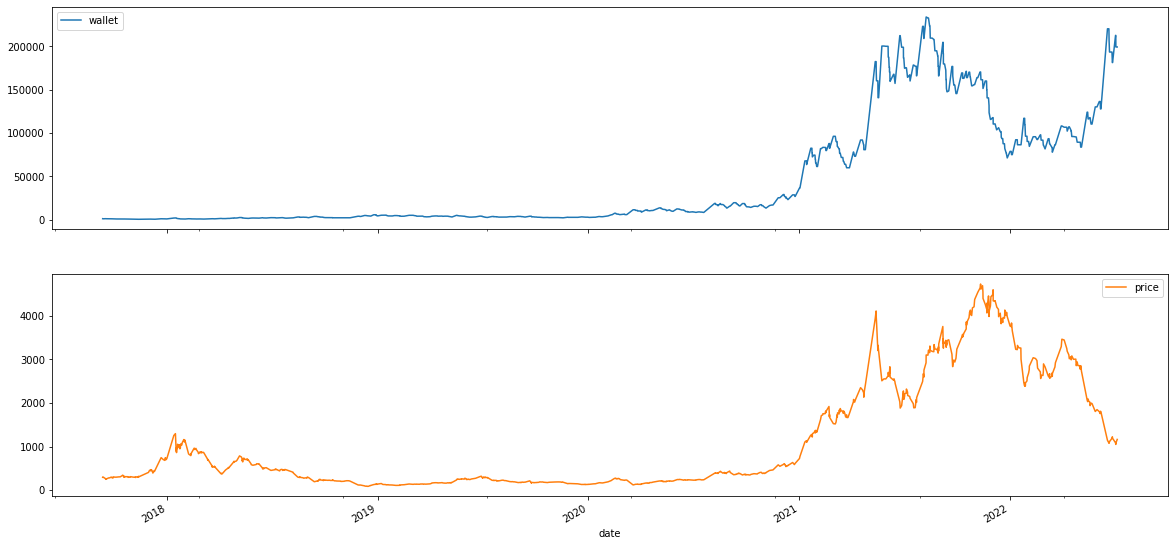

In [9]:
dt[['wallet', 'price']].plot(subplots=True, figsize=(20, 10))
print("\n----- Plot -----")